In [3]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from torchvision import models
import torch.nn as nn

import torch.optim as optim
import time

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d plantvillage


Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage

In [14]:
dataset_path = "plantvillage/PlantVillage"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std  = [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = False)

classes = full_dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Number of classes: {num_classes}")


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes: 15


In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 10):
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Val   Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining complete in {total_time // 60:.0f}m {total_time % 60:.0f}s")
    return model


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained = True)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 10)



Epoch 1/10
Train Loss: 0.8266 Acc: 0.7831
Val   Loss: 0.4037 Acc: 0.8883

Epoch 2/10
Train Loss: 0.3774 Acc: 0.8936
Val   Loss: 0.3157 Acc: 0.9067

Epoch 3/10
Train Loss: 0.2952 Acc: 0.9129
Val   Loss: 0.2693 Acc: 0.9172

Epoch 4/10
Train Loss: 0.2589 Acc: 0.9220
Val   Loss: 0.2348 Acc: 0.9254

Epoch 5/10
Train Loss: 0.2408 Acc: 0.9265
Val   Loss: 0.2268 Acc: 0.9271

Epoch 6/10
Train Loss: 0.2186 Acc: 0.9303
Val   Loss: 0.2222 Acc: 0.9290

Epoch 7/10
Train Loss: 0.2059 Acc: 0.9338
Val   Loss: 0.2105 Acc: 0.9324

Epoch 8/10
Train Loss: 0.1934 Acc: 0.9396
Val   Loss: 0.2039 Acc: 0.9314

Epoch 9/10
Train Loss: 0.1919 Acc: 0.9377
Val   Loss: 0.1966 Acc: 0.9365

Epoch 10/10
Train Loss: 0.1799 Acc: 0.9414
Val   Loss: 0.2111 Acc: 0.9302

Training complete in 13m 10s


In [17]:
torch.save(trained_model.state_dict(), "resnet18_plantvillage.pth")


In [18]:

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("resnet18_plantvillage.pth"))
model = model.to(device)
model.eval()


from sklearn.metrics import classification_report, accuracy_score
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Print overall accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.97      0.97       199
                     Pepper__bell___healthy       0.99      0.99      0.99       276
                      Potato___Early_blight       0.94      0.99      0.97       204
                       Potato___Late_blight       0.96      0.92      0.94       199
                           Potato___healthy       1.00      0.83      0.91        35
                      Tomato_Bacterial_spot       0.93      0.98      0.95       426
                        Tomato_Early_blight       0.88      0.74      0.81       194
                         Tomato_Late_blight       0.85      0.96      0.90       364
                           Tomato_Leaf_Mold       0.99      0.82      0.90       184
                  Tomato_Septoria_leaf_spot       0.88      0.88      0.88       361
Tomato_Spider_mites_Two_spotted_spider_m

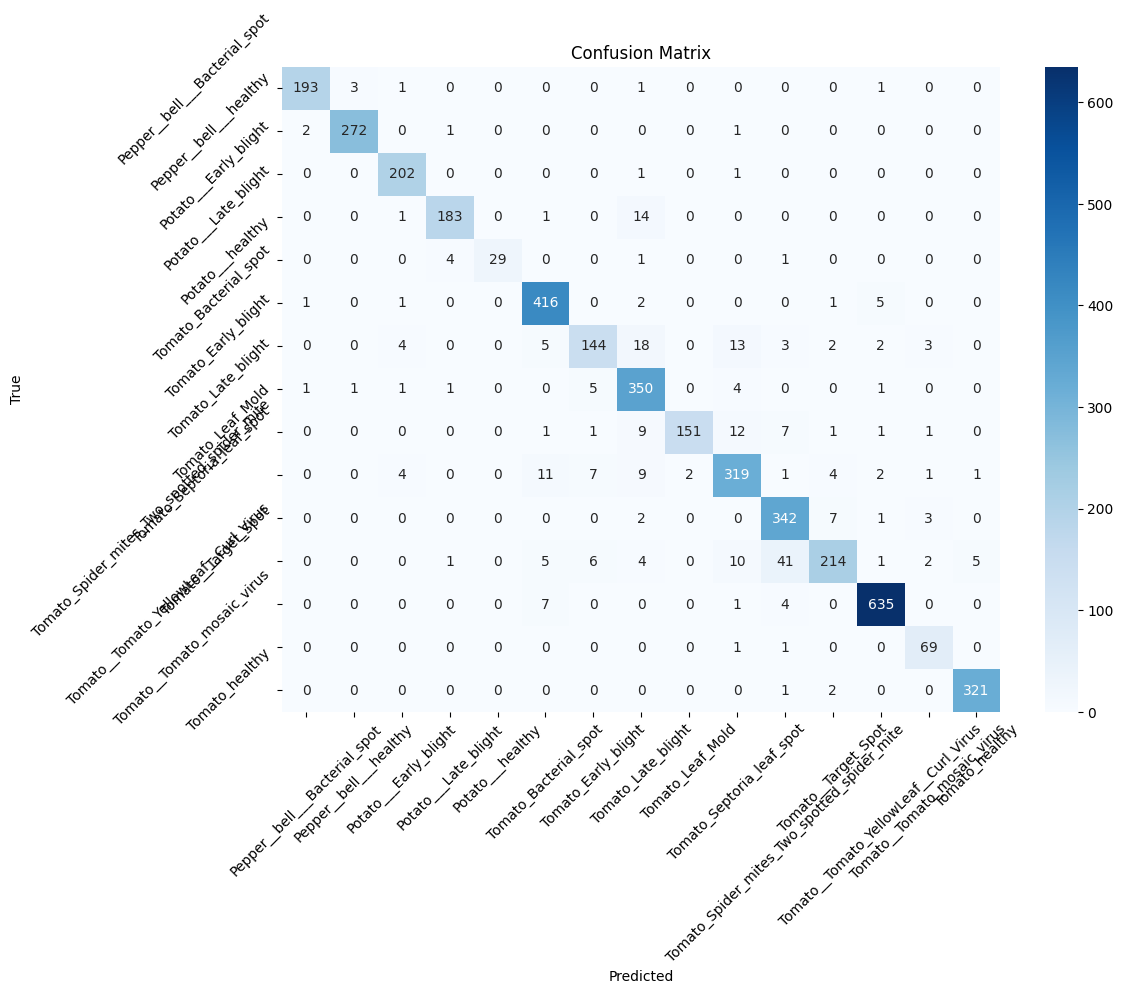

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
